In [2]:
!pip install pandas dask memory_profiler

In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import random
import string
import time
from memory_profiler import memory_usage

In [4]:
N = 10_000_000  # Número de registros
CAMBIO_USD_BRL = 5.10  # Cotação do dólar

# Custos por hora
CUSTO_AWS = 0.096
CUSTO_GCP = 0.067
CUSTO_AZURE = 0.052

# Custos por segundo
custo_por_segundo = {
    "AWS": CUSTO_AWS / 3600,
    "GCP": CUSTO_GCP / 3600,
    "Azure": CUSTO_AZURE / 3600,
}

In [5]:
def benchmark_sort(name, func, tipo, execucoes=5):
    print(f"\n📌 {name} - ({tipo}) - {execucoes} execuções")
    registros = []

    for i in range(execucoes):
        print(f"  🔁 Execução {i+1}/{execucoes}...")
        start_time = time.time()
        mem_usage = memory_usage((func,), max_usage=True, interval=0.5, timeout=None)
        tempo_execucao = time.time() - start_time
        max_mem = mem_usage

        # Custos em USD
        custo_aws = tempo_execucao * custo_por_segundo["AWS"]
        custo_gcp = tempo_execucao * custo_por_segundo["GCP"]
        custo_azure = tempo_execucao * custo_por_segundo["Azure"]

        # Custos em BRL
        custo_aws_brl = custo_aws * CAMBIO_USD_BRL
        custo_gcp_brl = custo_gcp * CAMBIO_USD_BRL
        custo_azure_brl = custo_azure * CAMBIO_USD_BRL

        registros.append({
            "biblioteca": name,
            "tipo": tipo,
            "execucao": i + 1,
            "tempo": tempo_execucao,
            "memória": max_mem,
            "custo_aws_usd": custo_aws,
            "custo_gcp_usd": custo_gcp,
            "custo_azure_usd": custo_azure,
            "custo_aws_brl": custo_aws_brl,
            "custo_gcp_brl": custo_gcp_brl,
            "custo_azure_brl": custo_azure_brl
        })

    return registros

In [9]:
def quicksort_manual(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr)//2]
    left   = [x for x in arr if x <  pivot]
    middle = [x for x in arr if x == pivot]
    right  = [x for x in arr if x >  pivot]
    return quicksort_manual(left) + middle + quicksort_manual(right)

def sort_manual_quicksort_numeros():
    arr = df_numeros['valor'].tolist()
    quicksort_manual(arr)

def sort_manual_quicksort_strings():
    arr = df_strings['valor'].tolist()
    quicksort_manual(arr)

In [8]:
# Dataframe de numeros
df_numeros = pd.DataFrame({
    "valor": np.random.rand(N)
})

# Strings aleatórias de 5 letras
def gerar_dataset_strings(n, tamanho=5):
    alfabeto = string.ascii_letters  # de A-Z + a-z
    dados = [''.join(random.choices(alfabeto, k=tamanho)) for _ in range(n)]
    return pd.DataFrame({"valor": dados})

df_strings = gerar_dataset_strings(N)

In [10]:
df_numeros.head()

,valor
0,0.188424
1,0.395112
2,0.136194
3,0.191060
4,0.588610


In [11]:
df_numeros.shape

(10000000, 1)

In [12]:
df_numeros.duplicated().sum()

np.int64(0)

In [13]:
df_strings.head()

,valor
0,mbUvp
1,BBVgL
2,AtJyi
3,YeczW
4,fgura


In [14]:
df_strings.shape

(10000000, 1)

In [15]:
df_strings.duplicated().sum()

np.int64(130537)

In [16]:
def sort_numpy_numeros():
    return np.sort(df_numeros["valor"].to_numpy(), kind="quicksort")

def sort_pandas_numeros():
    return df_numeros.sort_values("valor", kind="quicksort")

def sort_dask_numeros():
    ddf = dd.from_pandas(df_numeros, npartitions=4)
    return ddf.map_partitions(lambda d: d.sort_values("valor", kind="quicksort")).compute()

In [17]:
def sort_numpy_strings():
    return np.sort(df_strings["valor"].to_numpy(), kind="quicksort")

def sort_pandas_strings():
    return df_strings.sort_values("valor", kind="quicksort")

def sort_dask_strings():
    ddf = dd.from_pandas(df_strings, npartitions=4)
    return ddf.map_partitions(lambda d: d.sort_values("valor", kind="quicksort")).compute()

In [18]:
todos_resultados = []

In [19]:
# Numeros
for nome, func in [
    ('Manual QuickSort', sort_manual_quicksort_numeros),
    ('NumPy',             sort_numpy_numeros),
    ('Pandas',            sort_pandas_numeros),
    ('Dask',              sort_dask_numeros),
]:
    todos_resultados += benchmark_sort(nome, func, 'números')


📌 Manual QuickSort - (números) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 NumPy - (números) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 Pandas - (números) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 Dask - (números) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...


In [20]:
# Strings
for nome, func in [
    ('Manual QuickSort', sort_manual_quicksort_strings),
    ('NumPy',             sort_numpy_strings),
    ('Pandas',            sort_pandas_strings),
    ('Dask',              sort_dask_strings),
]:
    todos_resultados += benchmark_sort(nome, func, 'strings')


📌 Manual QuickSort - (strings) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 NumPy - (strings) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 Pandas - (strings) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...

📌 Dask - (strings) - 5 execuções
  🔁 Execução 1/5...
  🔁 Execução 2/5...
  🔁 Execução 3/5...
  🔁 Execução 4/5...
  🔁 Execução 5/5...


In [21]:
df_detalhado = pd.DataFrame(todos_resultados)
df_detalhado.head()

,biblioteca,tipo,execucao,tempo,memória,custo_aws_usd,custo_gcp_usd,custo_azure_usd,custo_aws_brl,custo_gcp_brl,custo_azure_brl
0,Manual QuickSort,números,1,43.907896,1714.367188,0.001171,0.000817,0.000634,0.005971,0.004168,0.003235
1,Manual QuickSort,números,2,47.179435,1716.113281,0.001258,0.000878,0.000681,0.006416,0.004478,0.003476
2,Manual QuickSort,números,3,46.431944,1715.578125,0.001238,0.000864,0.000671,0.006315,0.004407,0.003420
3,Manual QuickSort,números,4,48.877947,1715.363281,0.001303,0.000910,0.000706,0.006647,0.004639,0.003601
4,Manual QuickSort,números,5,48.371263,1740.523438,0.001290,0.000900,0.000699,0.006578,0.004591,0.003563


In [22]:
df_detalhado.shape

(40, 11)

In [23]:
df_detalhado.to_csv("resultados_detalhados.csv", index=False)

In [24]:
resumo = df_detalhado.groupby(["biblioteca", "tipo"]).agg({
    "tempo": ["mean", "median", "min", "max"]
}).reset_index()

In [25]:
resumo.columns = ["biblioteca", "tipo", "tempo_medio", "tempo_mediana", "tempo_min", "tempo_max"]

In [26]:
resumo.head()

,biblioteca,tipo,tempo_medio,tempo_mediana,tempo_min,tempo_max
0,Dask,números,1.314070,1.311920,1.227271,1.412463
1,Dask,strings,3.157377,3.162664,3.085290,3.259809
2,Manual QuickSort,números,46.953697,47.179435,43.907896,48.877947
3,Manual QuickSort,strings,71.015259,70.993828,69.950651,72.039560
4,NumPy,números,0.392367,0.391374,0.383444,0.401444


In [27]:
resumo

,biblioteca,tipo,tempo_medio,tempo_mediana,tempo_min,tempo_max
0,Dask,números,1.314070,1.311920,1.227271,1.412463
1,Dask,strings,3.157377,3.162664,3.085290,3.259809
2,Manual QuickSort,números,46.953697,47.179435,43.907896,48.877947
3,Manual QuickSort,strings,71.015259,70.993828,69.950651,72.039560
4,NumPy,números,0.392367,0.391374,0.383444,0.401444
5,NumPy,strings,18.002635,17.842649,17.394188,18.649801
6,Pandas,números,1.338831,1.343063,1.286489,1.383379
7,Pandas,strings,30.274953,30.360508,28.631620,32.129163


In [28]:
resumo.to_csv("resumo_estatistico.csv", index=False)

# Graficos

In [29]:
pivot_df = resumo.pivot(index="biblioteca", columns="tipo", values="tempo_medio")
pivot_df.head()

tipo,números,strings
biblioteca,,
Dask,1.314070,3.157377
Manual QuickSort,46.953697,71.015259
NumPy,0.392367,18.002635
Pandas,1.338831,30.274953


In [30]:
cores = ["#4FC3F7", "#0D47A1"]

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
sns.set_style("whitegrid")

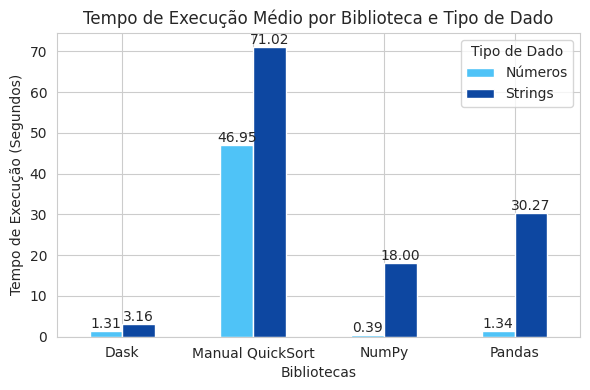

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

bars = pivot_df.plot(kind="bar", color=cores, ax=ax)

# Títulos e eixos
plt.title("Tempo de Execução Médio por Biblioteca e Tipo de Dado", fontsize=12)
plt.xlabel("Bibliotecas", fontsize=10)
plt.ylabel("Tempo de Execução (Segundos)", fontsize=10)
plt.xticks(rotation=0)
plt.legend(title="Tipo de Dado", labels=["Números", "Strings"])

# Rótulos nas barras
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', label_type='edge', padding=0.1)

plt.tight_layout()
plt.savefig("grafico_execucao_medio.png")
plt.show()

In [43]:
algoritmos = ['Dask', 'Manual QuickSort', 'NumPy', 'Pandas']
tipos = ['números', 'strings']

for alg in algoritmos:
    for tp in tipos:
        tempos = [
            r['tempo'] for r in todos_resultados
            if r['biblioteca'] == alg and r['tipo'] == tp
        ]
        plt.figure()
        plt.boxplot(tempos, labels=[tp.capitalize()])
        plt.title(f'Boxplot de Tempo – {alg} ({tp.capitalize()})')
        plt.ylabel('Tempo (segundos)')
        plt.xlabel(f'Tipo de dado: {tp.capitalize()}')

        nome_arquivo = f'boxplot_{alg.lower().replace(" ", "_")}_{tp}.png'
        plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
        plt.close()

<ipython-input-43-0f2549b08f40>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tempos, labels=[tp.capitalize()])
<ipython-input-43-0f2549b08f40>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tempos, labels=[tp.capitalize()])
<ipython-input-43-0f2549b08f40>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tempos, labels=[tp.capitalize()])
<ipython-input-43-0f2549b08f40>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tempos, labels=[tp.cap

## Comparacao Memoria

In [46]:
if 'memória' in df_detalhado.columns:
    df_detalhado.rename(columns={'memória': 'memoria'}, inplace=True)

novo_resumo = df_detalhado.groupby(['biblioteca', 'tipo'])['memoria'].mean().reset_index()
pivot = novo_resumo.pivot(index='biblioteca', columns='tipo', values='memoria')

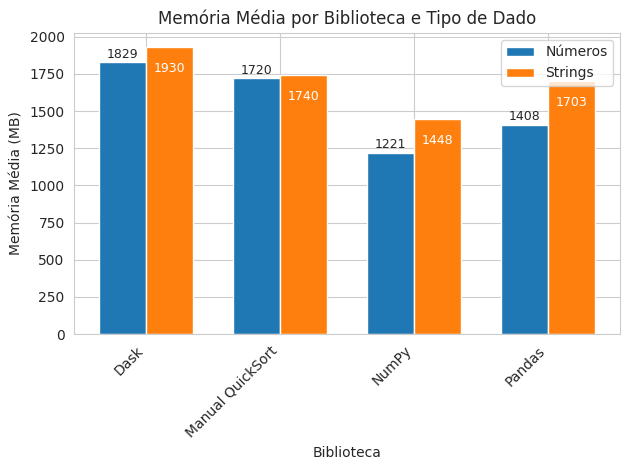

In [47]:
libs = pivot.index.tolist()
x = np.arange(len(libs))
width = 0.35

fig, ax = plt.subplots()
bars_num = ax.bar(x - width/2, pivot['números'], width, label='Números')
bars_str = ax.bar(x + width/2, pivot['strings'], width, label='Strings')

for bar in bars_num:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + 10,
        f'{h:.0f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

for bar in bars_str:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h - 100,
        f'{h:.0f}',
        ha='center',
        va='top',
        fontsize=9,
        color='white'
    )

ax.set_xticks(x)
ax.set_xticklabels(libs, rotation=45, ha='right')
ax.set_ylabel('Memória Média (MB)')
ax.set_xlabel('Biblioteca')
ax.set_title('Memória Média por Biblioteca e Tipo de Dado')
ax.legend()

plt.tight_layout()
plt.show()